In [1]:
import numpy as np
import ceo
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
gmt = ceo.GMT_MX()
src = ceo.Source("R",rays_box_size=25.5,rays_box_sampling=501,rays_origin=[0,0,25])
src>>(gmt,)

OPTICAL PATH: ['GMT_MX']


# Vignetting

In [3]:
+src
a0  = src.amplitude.host().sum()

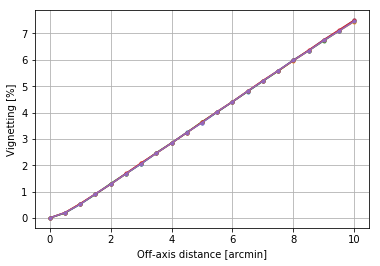

In [4]:
z_ = np.linspace(0,10,21)
o_ = [0,30,45,60,90]
for o in o_:
    v = []
    for z in z_:
        src.updateDirections(ceo.constants.ARCMIN2RAD*z,o*np.pi/180)
        +src
        a = src.amplitude.host().sum()
        v += [100*(a0-a)/a0]

    plt.plot(z_,v,'.-')
plt.grid()
plt.xlabel('Off-axis distance [arcmin]')
plt.ylabel('Vignetting [%]')

# Strehl ratio

## Vignetting

In the following the Strehl ratio as a function of field angle is estimated taking into account only the pupil vignetting.

In [8]:
src.updateDirections(0,0)
+src
sr0 = np.abs(np.sum(src.wavefront.amplitude.host()))**2
print sr0

19866338704.0


In [9]:
from numpy.random import rand
N_SAMPLE = 101
zen = np.linspace(0,10,N_SAMPLE)
strehlRatio_v = np.zeros(N_SAMPLE)
for k_SAMPLE in range(N_SAMPLE):
    src.updateDirections(zen[k_SAMPLE]*ceo.constants.ARCMIN2RAD,0)
    +src
    sr = np.abs(np.sum(src.wavefront.amplitude.host()))**2
    strehlRatio_v[k_SAMPLE] = sr/sr0

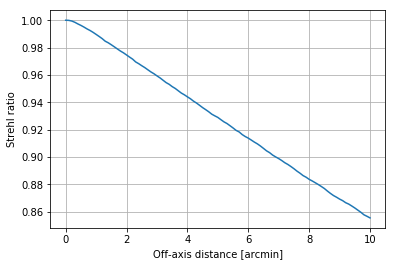

In [11]:
plt.plot(zen,strehlRatio_v)
plt.grid()
plt.xlabel('Off-axis distance [arcmin]')
plt.ylabel('Strehl ratio')

## Vignetting and field aberration

In the following the Strehl ratio as a function of field angle is estimated taking into account both the pupil vignetting and the field aberrations.

In [12]:
q = 2.*np.pi/src.wavelength

In [13]:
src.updateDirections(0,0)
+src
sr0 = np.abs(np.sum(src.wavefront.amplitude.host()*np.exp(1j*q*src.wavefront.phase.host())))**2
print sr0

19865233158.5


In [14]:
src.updateDirections(ceo.constants.ARCMIN2RAD*1.5,0)
+src
sr = np.abs(np.sum(src.wavefront.amplitude.host()*np.exp(1j*q*src.wavefront.phase.host())))**2
print sr/sr0

0.250335629062


In [15]:
from numpy.random import rand
N_SAMPLE = 101
zen = np.linspace(0,3,N_SAMPLE)
strehlRatio = np.zeros(N_SAMPLE)
for k_SAMPLE in range(N_SAMPLE):
    src.updateDirections(zen[k_SAMPLE]*ceo.constants.ARCMIN2RAD,0)
    +src
    sr = np.abs(np.sum(src.wavefront.amplitude.host()*\
                       np.exp(1j*q*src.wavefront.phase.host())))**2
    strehlRatio[k_SAMPLE] = sr/sr0

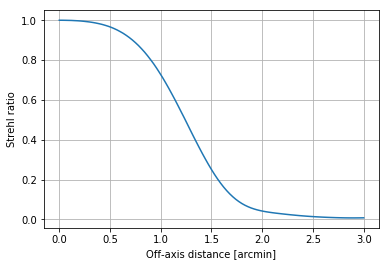

In [17]:
plt.plot(zen,strehlRatio)
plt.grid()
plt.xlabel('Off-axis distance [arcmin]')
plt.ylabel('Strehl ratio')

In [18]:
%%time 
from numpy.random import rand
N_SAMPLE = 1000
zen = np.zeros(N_SAMPLE)
azi = np.zeros(N_SAMPLE)
strehlRatio = np.zeros(N_SAMPLE)
for k_SAMPLE in range(N_SAMPLE):
    zen[k_SAMPLE] = ceo.constants.ARCMIN2RAD*1.5*np.sqrt(rand())
    azi[k_SAMPLE] = rand()*2*np.pi
    src.updateDirections(zen[k_SAMPLE],azi[k_SAMPLE])
    +src
    sr = np.abs(np.sum(src.wavefront.amplitude.host()*\
                       np.exp(1j*q*src.wavefront.phase.host())))**2
    strehlRatio[k_SAMPLE] = sr/sr0

CPU times: user 40.1 s, sys: 21.6 s, total: 1min 1s
Wall time: 1min 1s


In [19]:
import matplotlib.tri as tri
xx = zen*ceo.constants.RAD2ARCMIN*np.cos(azi)
yy = zen*ceo.constants.RAD2ARCMIN*np.sin(azi)
triang = tri.Triangulation(xx, yy)

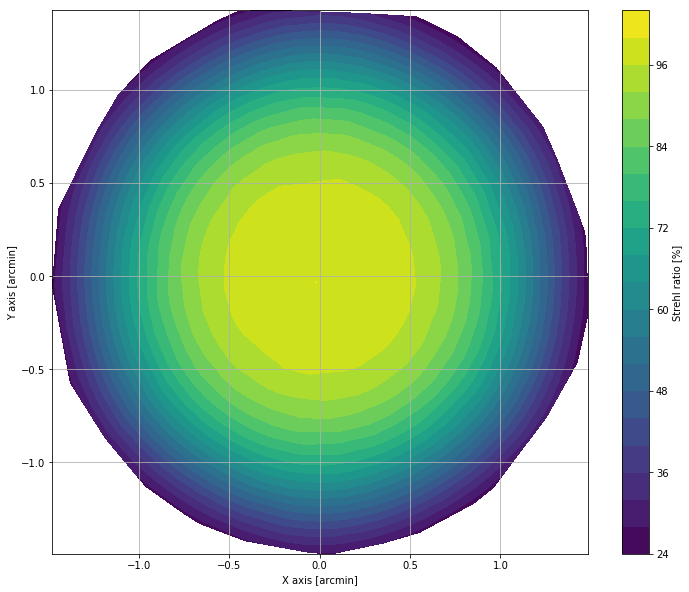

In [20]:
fig = plt.figure()
fig.set_size_inches(12,10)
ax = fig.gca()
h = ax.tricontourf(triang,100*strehlRatio,21,cmap='viridis',shading='gouraud')
plt.colorbar(h,ax=ax,label='Strehl ratio [%]')
plt.grid()
plt.xlabel('X axis [arcmin]')
plt.ylabel('Y axis [arcmin]')

# FWHM

In [170]:
src.updateDirections(0,0)
+src

In [171]:
def psf(fx,fy):
    u = np.arange(src.rays.N_L) - (src.rays.N_L-1)*0.5
    k,l = np.meshgrid(u,u)
    delta = src.rays.L/(src.rays.N_L-1)
    P = src.amplitude.host()
    phasor = 2*np.pi*delta*(k*fx+l*fy)
    return np.abs(np.sum(P*np.exp(-1j*phasor)))**2

In [172]:
psf00 = psf(0,0)

In [173]:
def npsf(fx,fy):
    return psf(fx,fy)/psf(0,0)

In [174]:
npsf(0.5/25.5,0)

0.55380703694322619

In [175]:
def hwhm_root(r,o):
    x = r*np.cos(o)
    y = r*np.sin(o)
    return npsf(x,y) - 0.5

In [176]:
print hwhm_root(0,0), hwhm_root(1/25.5,0)

0.5 -0.449370166664


In [177]:
from scipy.optimize import brentq

In [178]:
he = brentq(fwhm_root,0,1/src.rays.L,args=(0,))
print he*src.rays.L, npsf(he,0)

0.539030328461 0.5


In [179]:
he = brentq(fwhm_root,0,1/src.rays.L,args=(np.pi/2,))
print he*src.rays.L, npsf(he,0)

0.538851132898 0.500245836113


In [180]:
def hwhm(theta):
    out = np.zeros(len(theta))
    for k in range(out.size):
        out[k] = brentq(hwhm_root,0,1/src.rays.L,args=(theta[k],))
    return out*src.wavelength*ceo.constants.RAD2MAS

In [181]:
o = np.linspace(0,2*np.pi,41)
he0 = hwhm(o)

In [182]:
he0

array([ 2.79047493,  2.79030295,  2.7899269 ,  2.78965039,  2.78969091,
        2.79000307,  2.79031709,  2.79036155,  2.79008926,  2.7897173 ,
        2.78954727,  2.7897173 ,  2.79008926,  2.79036155,  2.79031709,
        2.79000307,  2.78969091,  2.78965039,  2.7899269 ,  2.79030295,
        2.79047493,  2.79030295,  2.7899269 ,  2.78965039,  2.78969091,
        2.79000307,  2.79031709,  2.79036155,  2.79008926,  2.7897173 ,
        2.78954727,  2.7897173 ,  2.79008926,  2.79036155,  2.79031709,
        2.79000307,  2.78969091,  2.78965039,  2.7899269 ,  2.79030295,
        2.79047493])

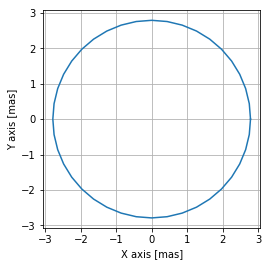

In [183]:
plt.plot(he0*np.cos(o),he0*np.sin(o))
plt.axis('square')
plt.grid()
plt.xlabel('X axis [mas]')
plt.ylabel('Y axis [mas]')

In [184]:
src.updateDirections(ceo.constants.ARCMIN2RAD*10,0)
+src
he = hwhm(o)

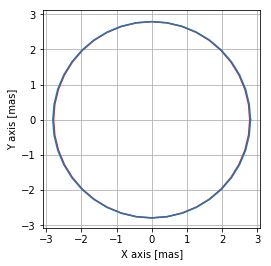

In [185]:
plt.plot(he0*np.cos(o),he0*np.sin(o),'C3')
plt.plot(he*np.cos(o),he*np.sin(o))
plt.axis('square')
plt.grid()
plt.xlabel('X axis [mas]')
plt.ylabel('Y axis [mas]')

In [186]:
n = 21
u = np.arange(n)/src.rays.L/4
psfn00 = np.zeros(n)
psfn   = np.zeros(n)
for k in range(n):
    u = k/src.rays.L/n
    src.updateDirections(0,0)
    +src
    psfn00[k] = npsf(u,0)
    src.updateDirections(10*ceo.constants.ARCMIN2RAD,0)
    +src
    psfn[k] = npsf(u,0)

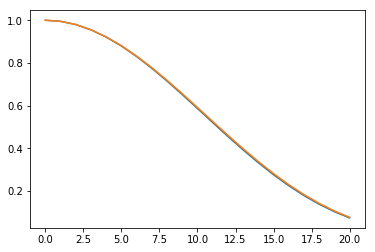

In [187]:
plt.plot(psfn00)
plt.plot(psfn)

In [190]:
N_SAMPLE = 41
zen = np.linspace(0,10,N_SAMPLE)
he = np.zeros(N_SAMPLE)
for k_SAMPLE in range(N_SAMPLE):
    src.updateDirections(zen[k_SAMPLE]*ceo.constants.ARCMIN2RAD,0)
    +src
    he[k_SAMPLE] = hwhm([0])

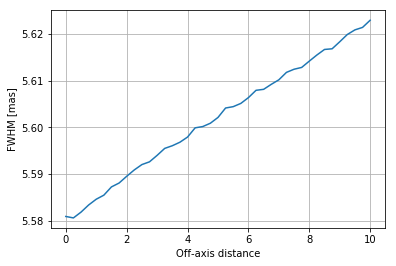

In [192]:
plt.plot(zen,he*2)
plt.grid()
plt.xlabel('Off-axis distance')
plt.ylabel('FWHM [mas]')

# Pupil distorsion

In [22]:
gmt = ceo.GMT_MX()
src = ceo.Source("R",rays_box_size=25.5,rays_box_sampling=41,rays_origin=[0,0,25])
src>>(gmt,)

OPTICAL PATH: ['GMT_MX']


In [23]:
src.updateDirections(0,0)
+src
V0 = src.rays.vignetting.host().flatten()
xyz0 = src.rays.coordinates.host()

In [24]:
src.updateDirections(ceo.constants.ARCMIN2RAD*5,np.pi/4)
+src
V = src.rays.vignetting.host().flatten()
M = V0*V>0
xyz = src.rays.coordinates.host()

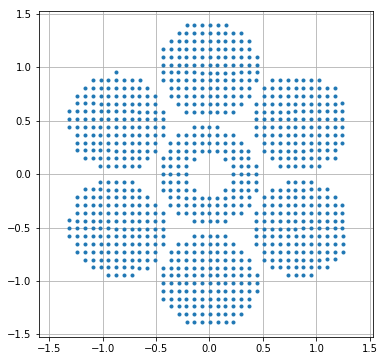

In [25]:
plt.figure(figsize=(6,6))
plt.plot(xyz[M,0],xyz[M,1],'.')
plt.axis('equal')
plt.grid()

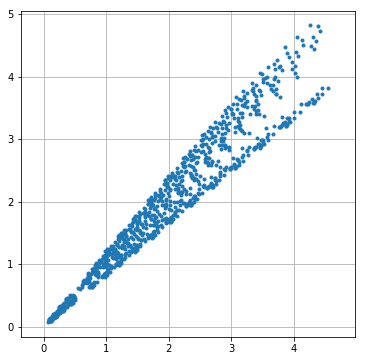

In [26]:
plt.figure(figsize=(6,6))
plt.plot(1e3*(xyz[M,0]-xyz0[M,0]),1e3*(xyz[M,1]-xyz0[M,1]),'.')
plt.axis('equal')
plt.grid()

(-1.4384290956794754,
 1.3733144499760468,
 17.878609053541172,
 17.947137655502086)

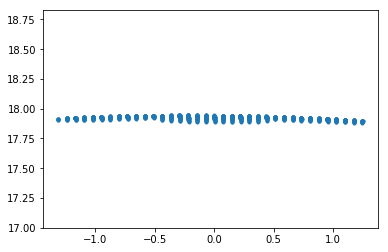

In [29]:
plt.plot(xyz[M,0],xyz[M,2],'.')
plt.axis('equal')

(-1.5222354625538763,
 1.5296331533951495,
 17.878609053541172,
 17.947137655502086)

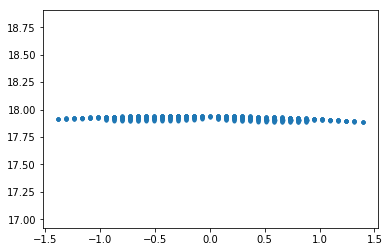

In [30]:
plt.plot(xyz[M,1],xyz[M,2],'.')
plt.axis('equal')